In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.2 MB/s 
     |████████████████████████████████| 46 kB 2.5 MB/s 
     |████████████████████████████████| 1.2 MB 33.2 MB/s 
     |████████████████████████████████| 186 kB 64.6 MB/s 
     |████████████████████████████████| 56 kB 2.8 MB/s 
     |████████████████████████████████| 51 kB 298 kB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [13]:
Path.BASE_PATH = path
path

Path('.')

In [36]:
# get the dataframe containing information from the dataset
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [37]:
# make functions to get x and y from the df
def get_y(row):
  return row['labels'].split(' ')

def get_x(row):
  return path/'train'/row['fname']

row_1 = df.iloc[0]
row_1

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [38]:
get_x(row_1), get_y(row_1)

(Path('train/000005.jpg'), ['chair'])

In [39]:
# create a splitting function based on the validation label
def split(df):
  train = df.index[df['is_valid']].to_list()
  valid = df.iloc[~df.index.isin(train)].index.to_list()
  return train, valid

In [40]:
split(df)[0][:10], split(df)[1][:10]

([0, 1, 2, 4, 6, 7, 8, 10, 12, 18], [3, 5, 9, 11, 13, 14, 15, 16, 17, 20])

In [44]:
# create a data block that uses get_x, get_y, and splitter for multilabel cat
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x,
                   get_y=get_y,
                   splitter=split)

dsets = dblock.datasets(df)

dsets.train[0][0], dsets.train.vocab[torch.where(dsets.train[0][1]==1)[0]]

(PILImage mode=RGB size=500x375, (#1) ['chair'])

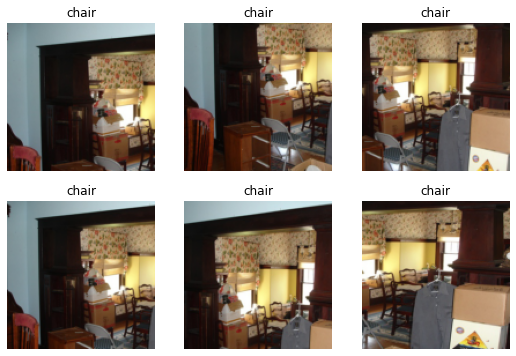

In [45]:
# seems to be working, now create a dataloader to finish it up
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x,
                   get_y=get_y,
                   splitter=split,
                   item_tfms = RandomResizedCrop(size=128, min_scale=0.35))

dls = dblock.dataloaders(df)
dls.show_batch(unique=True, nrows=2, ncols = 3)

## Binary CE Loss

In [46]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [50]:
# get the activations from the final layer of the model
x, y = to_cpu(dls.train.one_batch())
x.shape, y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 20]))

In [51]:
# get the activaitons for the final layer
act = learn.model(x)
act.shape, act[0]

(torch.Size([64, 20]),
 tensor([-0.5949, -2.2028,  1.6649,  1.9414,  2.6542,  0.9772,  2.5110,  0.9275, -0.2401, -1.1107,  1.4192, -0.3190,  0.5769,  2.7030, -0.2650, -0.6261, -1.0791,  4.4856, -0.0157, -1.0415],
        grad_fn=<SelectBackward>))

In [54]:
# create BCE loss from these activations
def manual_bce_loss(acts, targ):
  acts = acts.sigmoid()
  return -torch.where(targ == 1, acts, 1-acts).log().mean()

manual_bce_loss(act, y), nn.BCEWithLogitsLoss()(act, y)

(TensorMultiCategory(1.0937, grad_fn=<AliasBackward>),
 TensorMultiCategory(1.0937, grad_fn=<AliasBackward>))

In [55]:
learn = cnn_learner(dls, resnet34, metrics=partial(accuracy_multi, thresh=0.4), loss_func=manual_bce_loss)
# should fine lr here to pass into base lr then unfreeze model, find lr again and train for more epochs
# use this approach here just to be simplistic
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.947628,0.651611,0.510416,00:28
1,0.703597,0.257332,0.906078,00:28


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.262774,0.162650,0.947581,00:29
1,0.194070,0.125918,0.957197,00:29
2,0.156534,0.120737,0.958317,00:29


In [61]:
# see if we can pick a threshold hyperparamter 
preds, targs = learn.get_preds()
accuracy_multi(preds, targs, thresh=0.7, sigmoid=False)

TensorBase(0.9563)

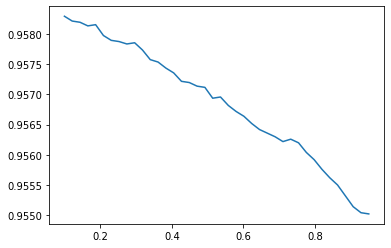

In [68]:
poss_thresh = torch.linspace(0.1,0.95,40)
accs = [accuracy_multi(preds, targs, thresh=thresh, sigmoid=False) for thresh in poss_thresh]
plt.plot(poss_thresh, accs)